In [1]:
import math
import torch

import gpytorch
import pyro
import pyro.distributions
import tqdm.notebook
import matplotlib.pyplot as plt


from scripts.Model import NeuroCluster

import pyro
import pyro.optim
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

import torch.nn.utils.rnn as rnn
import numpy as np
import functools


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
batch_size = 60
intensity_max = 30
true_intensity_functions = [lambda times: torch.cos(times * 2 * math.pi).add(1).mul(intensity_max / 2.),
                            lambda times: torch.cos(times * 2 * math.pi + math.pi).add(1).mul(intensity_max / 2.)]

In [3]:
max_time = 3

times = torch.linspace(0, max_time, 128)
true_class = np.random.randint(0, 2, batch_size)
num_samples = [int(pyro.distributions.Poisson(true_intensity_functions[true_class[i]](times).mean() * max_time).sample().item()) for i in range(batch_size)]

print(f"Number of sampled arrivals: {num_samples}")

Number of sampled arrivals: [40, 38, 46, 45, 45, 40, 38, 37, 42, 43, 62, 52, 45, 47, 38, 45, 51, 38, 46, 49, 42, 47, 29, 48, 54, 32, 45, 50, 29, 38, 40, 49, 44, 43, 51, 61, 51, 34, 58, 37, 49, 40, 52, 41, 33, 53, 35, 57, 43, 36, 43, 48, 41, 56, 47, 47, 51, 31, 40, 53]


In [4]:
def log_prob_accept(val, i):
    intensities = true_intensity_functions[true_class[i]](val)
    res = torch.log(intensities / (true_intensity_functions[true_class[i]](times).mean() * max_time))
    return res

arrival_times = [pyro.distributions.Rejector(
    propose=pyro.distributions.Uniform(times.min(), times.max()),
    log_prob_accept=functools.partial(log_prob_accept, i=i),
    log_scale=0.
)(torch.Size([sample_num])) for i, sample_num in enumerate(num_samples)]

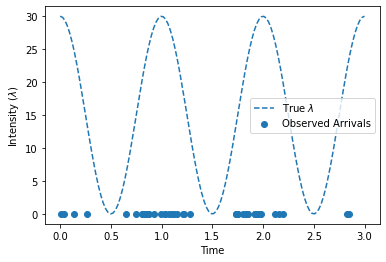

In [5]:
n = 20
fig, ax = plt.subplots(1, 1)
ax.plot(times, true_intensity_functions[true_class[n]](times), "--", label=r"True $\lambda$")
ax.set_xlabel("Time")
ax.set_ylabel("Intensity ($\lambda$)")
ax.scatter(arrival_times[n], torch.zeros_like(arrival_times[n]), label=r"Observed Arrivals")
ax.legend(loc="best")

In [6]:
print(true_class)

[1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0
 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1]


In [7]:
class PackedSequence:
    def __init__(self, data, batch_sizes):
        self.data = data
        self.batch_sizes = batch_sizes
        self.batch_num = len(batch_sizes)


    def __str__(self):
        return f"(data={self.data}, batch_sizes={self.batch_sizes})"

pad_seq = PackedSequence(torch.cat(arrival_times), [int(arrives.size()[0]) for arrives in arrival_times])
ave_arrivals = np.mean([data_i.numel() for data_i in arrival_times])
print(pad_seq)

(data=tensor([1.1735, 1.6838, 0.6585,  ..., 2.8155, 1.2887, 1.4233]), batch_sizes=[40, 38, 46, 45, 45, 40, 38, 37, 42, 43, 62, 52, 45, 47, 38, 45, 51, 38, 46, 49, 42, 47, 29, 48, 54, 32, 45, 50, 29, 38, 40, 49, 44, 43, 51, 61, 51, 34, 58, 37, 49, 40, 52, 41, 33, 53, 35, 57, 43, 36, 43, 48, 41, 56, 47, 47, 51, 31, 40, 53])


In [8]:
cluster_num=2
model = NeuroCluster(ave_arrivals, max_time, class_num=cluster_num, num_inducing=64)

model.covar_module.base_kernel.raw_lengthscale.data = \
    torch.tensor([[[0.1]],[[0.1]]])

In [9]:
quadrature_times = torch.linspace(0, max_time, 64)


In [10]:
import os
smoke_test = ('CI' in os.environ)
num_iter = 2 if smoke_test else 10000
num_particles = 1 if smoke_test else 32

#Todo cluster_ratio
def train(lr=0.01):

    optimizer = pyro.optim.Adam({"lr":lr})
    loss = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    infer = pyro.infer.SVI(model.model, model.guide, optimizer, loss=loss)

    model.train()
    loader = tqdm.notebook.tqdm(range(num_iter))
    #estimated_cluster = model.expectation(pad_seq, quadrature_times)
    estimated_cluster = torch.eye(cluster_num)[torch.multinomial(model.cluster_ratio,
                                                                 replacement=True,
                                                                 num_samples=batch_size)]
    for i in loader:
        loss = infer.step(pad_seq, quadrature_times, estimated_cluster)
        if i % 50 ==0:
            estimated_cluster = model.expectation(pad_seq, quadrature_times)
        loader.set_postfix(loss=loss)

train()

  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([1000, 64, 2])


Text(0, 0.5, 'Intensity ($\\lambda$)')

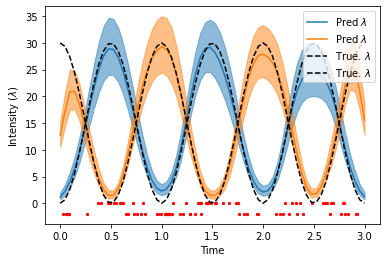

In [15]:
# Here's a quick helper function for getting smoothed percentile values from samples
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentile_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples


model.eval()
with torch.no_grad():
    function_dist = model(quadrature_times)
    intensity_samples = function_dist(torch.Size([1000])).exp() * model.mean_intensity
    print(intensity_samples.shape)

def plot_prediction(ax, samples, quadrature_times):
    # Plot the predicted intensity function

    lower, mean, upper = percentiles_from_samples(samples)
    line, = ax.plot(quadrature_times, mean, label=r"Pred $\lambda$")
    ax.fill_between(quadrature_times, lower, upper, color=line.get_color(), alpha=0.5)




fig, ax = plt.subplots(1, 1)

plot_prediction(ax, intensity_samples[:, :, 1],
                quadrature_times, )
plot_prediction(ax, intensity_samples[:, :, 0],
                quadrature_times, )
ax.plot(quadrature_times, true_intensity_functions[0](quadrature_times), "--", color="k", label=r"True. $\lambda$")
ax.plot(quadrature_times, true_intensity_functions[1](quadrature_times), "--", color="k", label=r"True. $\lambda$")
ax.scatter(arrival_times[5], torch.zeros(arrival_times[5].shape), s=5, c="red")
ax.scatter(arrival_times[13], torch.zeros(arrival_times[13].shape)-2, s=5, c="red")
ax.legend(loc="upper right")
ax.set_xlabel("Time")
ax.set_ylabel("Intensity ($\lambda$)")

In [16]:
print(model.cluster_ratio)

tensor([0.5833, 0.4167])


In [13]:
print(list(model.named_parameters()))

[('variational_strategy.base_variational_strategy.inducing_points', Parameter containing:
tensor([[-0.0874],
        [-0.0205],
        [ 0.0586],
        [ 0.1413],
        [ 0.2277],
        [ 0.3066],
        [ 0.3833],
        [ 0.4703],
        [ 0.5426],
        [ 0.6301],
        [ 0.7095],
        [ 0.7876],
        [ 0.8583],
        [ 0.9282],
        [ 0.9924],
        [ 1.0476],
        [ 1.1069],
        [ 1.1637],
        [ 1.2138],
        [ 1.2610],
        [ 1.3010],
        [ 1.3438],
        [ 1.3821],
        [ 1.4202],
        [ 1.4571],
        [ 1.4903],
        [ 1.5251],
        [ 1.5632],
        [ 1.6081],
        [ 1.6530],
        [ 1.7069],
        [ 1.7666],
        [ 1.8229],
        [ 1.8947],
        [ 1.9495],
        [ 2.0202],
        [ 2.0879],
        [ 2.1420],
        [ 2.1925],
        [ 2.2429],
        [ 2.2843],
        [ 2.3167],
        [ 2.3507],
        [ 2.3654],
        [ 2.3956],
        [ 2.4318],
        [ 2.4784],
        [ 2.5511]